Notes for HST photometry project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
model = Table.read('../paper/saved_models/trappist-1_model_var_res_v07.ecsv')
mw, mf = model['WAVELENGTH'], model['FLUX']

Filters to look at 
 
 ACS/SBC F140LP - F165LP = C IV  
  F280N   
  F218W and F225W  
  
  

In [5]:
#uvispath = '/home/david/work/filters/wfc3/UVIS'
from svo_filters import svo

In [58]:
F280N = svo.Filter('WFC3_UVIS1.F280N')

In [60]:
F280N.info()

     Attributes                                                 Values                                          
-------------------- -------------------------------------------------------------------------------------------
            Comments />                                                                                         
        DetectorType 1                                                                                          
            Facility HST                                                                                        
FilterProfileService ivo://svo/fps                                                                              
          Instrument WFC3                                                                                       
              MagSys Vega                                                                                       
           PhotCalID HST/WFC3_UVIS1.F280N/Vega                                                  

In [103]:
filters =  ['WFC3_UVIS1.F280N', 'WFC3_UVIS1.F218W', 'WFC3_UVIS1.F225W', 'WFC3_UVIS1.F275W', 'ACS_SBC.F140LP', 'ACS_SBC.F165LP']

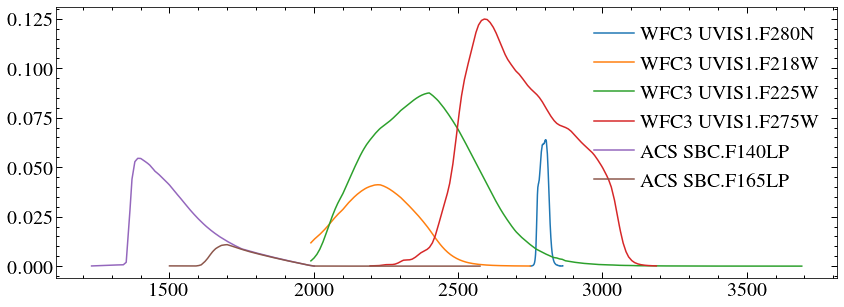

In [104]:
for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0]*10000, bp.throughput[0]
    #print(bp.name)
    plt.plot(bpw, bpf, label = r'{}'.format(bp.name.replace('_', ' ')))

plt.legend()

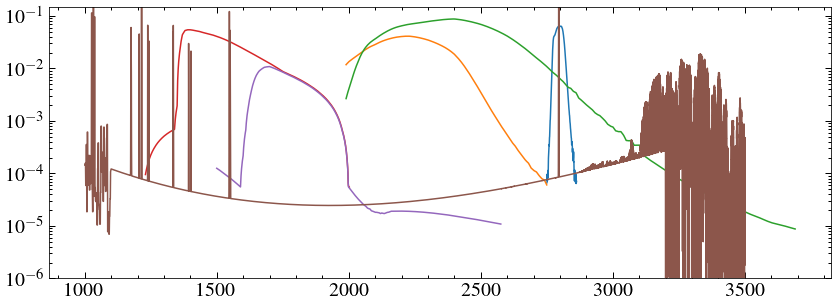

In [98]:

for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = bp.wave[0]*10000, bp.throughput[0]
    #print(bp.name)
    plt.plot(bpw, bpf, label = r'{}'.format(bp.name.replace('_', ' ')))

#plt.legend()
mask = (mw > 1000) & (mw < 3500)
umw, umf =  mw[mask], mf[mask]
plt.plot(umw, umf*5e14)
plt.ylim(0.000001, 0.15)
plt.yscale('log')

Plan- make a model spectrum file for each filter. Try with just a short one first,

In [94]:
for flt in filters:
    bp =  svo.Filter(flt)
    bpw, bpf = (bp.wave[0].value)*10000, bp.throughput[0]
    print(bpw[0], bpw[-1])

2750.5002 2863.0
1990.0 2750.0
1990.0 3691.0
1230.0 2002.0001
1500.0 2576.0


In [96]:
#1230.0 3691.0
mask = (mw > 1220) & (mw < 3700)
umw, umf =  mw[mask], mf[mask]
savdat = Table([umw, umf], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 't1uv_model.dat', format='basic', overwrite=True)